**CIS 4190: Applied Machine Learning**

# **Final Project - News Source Classification (B)**

**Team Members:** Maya Kfir, Derrick Vincent, Elize Dracopoulos

**Project Overview:**  

In this project, we aim to classify news headlines by their source (Fox News vs NBC News) using ML techniques learned during the semester.

We will collect headlines through web scraping, preprocess the text data, and train various classification models to predict the news source based on headline content.

**Goal:** Improve upon the baseline accuracy of 66.49% and analyze different modeling approaches.




---

## Main Notebook - ML Pipeline

This notebook contains the core machine learning pipeline: data preprocessing, baseline model, model development, and evaluation.


### **Related Notebooks**

This is the main notebook for the ML pipeline. For data collection, see:
- **[Data Collection Notebook (collab)](https://colab.research.google.com/drive/1rCIBTb64CIaVl21uU9jFoMbJtHW4xbIv?usp=sharing)** - Web scraping pipeline
- **[Fox-NBC News Daily Headline Scraper (git)](https://github.com/maya2816/fox-nbc-news-daily-headline-scraper)** - Automated data collection engine


---

## **1. Setup and Installation**

Install required Python packages for data processing and machine learning, and load the scraped headlines dataset.

**Note:** This notebook focuses on the ML pipeline. The web scraping pipeline is handled separately in the [Data Collection Notebook](https://colab.research.google.com/drive/1rCIBTb64CIaVl21uU9jFoMbJtHW4xbIv?usp=sharing)

#### **1.1 Import Libraries**

Import all necessary libraries for data processing and machine learning.

In [ ]:
%pip install scikit-learn pandas numpy matplotlib nltk


In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# For text preprocessing (stopwords and lemmatization)
try:
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    # Download required NLTK data if needed
    print("Checking NLTK data...")

    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        print("Downloading punkt...")
        nltk.download('punkt', quiet=True)

    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        print("Downloading stopwords...")
        nltk.download('stopwords', quiet=True)

    try:
        nltk.data.find('corpora/wordnet')
        print("NLTK data ready!")
    except LookupError:
        print("Downloading wordnet (this may take a moment)...")
        nltk.download('wordnet', quiet=True)
        print("Wordnet downloaded successfully!")
except ImportError:
    print("Note: NLTK not available. Some preprocessing features may be limited.")
    stopwords = None
    WordNetLemmatizer = None


Checking NLTK data...
Wordnet downloaded successfully!


---

## **2. Load Dataset (Data Collection)**
**Responsible: Maya Kfir**

The data collection process is handled in its own individual notebook [Data Collection Notebook](data_collection.ipynb), which implements the scraping pipeline:

* **input**: `url_only_data.csv` - provided URLs to headline pages.

* **output:** `scraped_data.csv` - all scraped headlines, corresponding news-source, and URL.

In this section we will load that dataset from a shared foleder.

**Instructions:**

1. Download `scraped_data.csv` from the shared [Google Drive folder](https://drive.google.com/drive/folders/1aL1XihVewKl_Uz_-mAllUobb0SH2UMy_?usp=drive_link)
2. In Colab, click the **Files** icon (left sidebar)
3. Click **Upload** button
4. Select and upload `scraped_data.csv`
5. Run the next cell to load and preview the data

**Note:** If you need to collect new data, run the [Data Collection Notebook](data_collection.ipynb) first.

In [ ]:
## -------------------------------------------------
## Load and preview scraped data
## -------------------------------------------------
import os

print("=" * 60)
print("Loading Scraped Headlines Dataset")
print("=" * 60)

# Check if file exists
if not os.path.exists("scraped_data.csv"):
    print("\n" + "=" * 60)
    print("ERROR: scraped_data.csv NOT FOUND")
    print("=" * 60)
    print("\nPlease download scraped_data.csv from:")
    print("   https://drive.google.com/drive/folders/1aL1XihVewKl_Uz_-mAllUobb0SH2UMy_?usp=drive_link")
    print("\nUpload to Colab:")
    print("   1. Click Files icon (left sidebar)")
    print("   2. Click Upload button")
    print("   3. Upload scraped_data.csv")
    print("   4. Re-run this cell")
    print("\n" + "=" * 60)
    raise FileNotFoundError(
        "scraped_data.csv is missing. Download from Google Drive and upload to Colab."
    )

# Load the scraped data
df = pd.read_csv("scraped_data.csv")

print(f"\nDataset loaded successfully!")
print(f"   Total rows: {len(df)}")
print(f"   Columns: {list(df.columns)}")

# Check for missing values
print(f"\nMissing values:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "   None")

# Remove any rows with missing headlines
initial_count = len(df)
df = df.dropna(subset=['headline'])
removed = initial_count - len(df)
if removed > 0:
    print(f"\nRemoved {removed} rows with missing headlines")

# Display distribution by source
print(f"\nDistribution by source:")
source_dist = df['source'].value_counts() # Changed 'source' to 'label'
for source, count in source_dist.items():
    percentage = (count / len(df)) * 100
    print(f"   {source}: {count} ({percentage:.1f}%)")

# Display sample data
print(f"\nSample data (first 5 rows):")
df.head()

Loading Scraped Headlines Dataset

Dataset loaded successfully!
   Total rows: 3805
   Columns: ['url', 'source', 'headline']

Missing values:
   None

Distribution by source:
   FoxNews: 2000 (52.6%)
   NBC: 1805 (47.4%)

Sample data (first 5 rows):


,url,source,headline
0,https://www.foxnews.com/lifestyle/jack-carrs-e...,FoxNews,jack carrs eisenhower d days memo noble undert...
1,https://www.foxnews.com/entertainment/bruce-wi...,FoxNews,bruce willis demi moore avoided doing one thin...
2,https://www.foxnews.com/politics/blinken-meets...,FoxNews,blinken meets with qatars prime minister
3,https://www.foxnews.com/entertainment/emily-bl...,FoxNews,emily blunt says toes curl when people their k...
4,https://www.foxnews.com/media/the-view-co-host...,FoxNews,the view co host cnn commentator ana navarro h...


---

## **3. Data Cleaning & Preprocessing**
**Responsible: Derrick Vincent**

This section covers text normalization, cleaning, and multiple preprocessing versions to prepare the data for modeling.


### **3.1 Basic Text Cleaning**

**Tasks:**
- Normalize text: lowercase, remove punctuation, remove special characters
- Remove duplicates & broken/empty headlines
- Handle missing or incomplete data


In [ ]:
## -------------------------------------------------
## Step 1: Load scraped data
## -------------------------------------------------

print("=" * 60)
print("STEP 3.1: Basic Text Cleaning")
print("=" * 60)

# Load the scraped data
# Create df_cleaning from loaded df
df_cleaning = df.copy()

print(f"\nInitial Dataset Statistics:")
print(f"   Total rows: {len(df_cleaning)}")
print(f"   Columns: {list(df_cleaning.columns)}")

# Check for missing values
print(f"\nMissing Values:")
print(df_cleaning.isnull().sum())

# Check data types
print(f"\nData Types:")
print(df_cleaning.dtypes)

STEP 3.1: Basic Text Cleaning

Initial Dataset Statistics:
   Total rows: 3805
   Columns: ['url', 'source', 'headline']

Missing Values:
url         0
source      0
headline    0
dtype: int64

Data Types:
url         object
source      object
headline    object
dtype: object


In [ ]:
## -------------------------------------------------
## Step 2: Remove duplicates and empty headlines
## -------------------------------------------------

print("\n" + "=" * 60)
print("Removing Duplicates and Empty Headlines")
print("=" * 60)

# Count before cleaning
initial_count = len(df_cleaning)
print(f"\nBefore cleaning: {initial_count} rows")

# Remove rows with missing headlines
df_cleaning = df_cleaning.dropna(subset=['headline'])

# Remove empty headlines (whitespace only)
df_cleaning = df_cleaning[df_cleaning['headline'].str.strip() != '']

# Remove duplicate headlines (same text)
df_cleaning = df_cleaning.drop_duplicates(subset=['headline'], keep='first')

if 'url' in df.columns:
  # Remove duplicate URLs (same URL)
  df_cleaning = df_cleaning.drop_duplicates(subset=['url'], keep='first')

# Count after cleaning
final_count = len(df_cleaning)
removed = initial_count - final_count

print(f"After cleaning: {final_count} rows")
print(f"Removed: {removed} rows ({removed/initial_count*100:.2f}%)")


Removing Duplicates and Empty Headlines

Before cleaning: 3805 rows
After cleaning: 3795 rows
Removed: 10 rows (0.26%)


In [ ]:
## -------------------------------------------------
## Step 3: Basic text normalization
## -------------------------------------------------

print("\n" + "=" * 60)
print("Basic Text Normalization")
print("=" * 60)

def normalize_text_basic(text):
    """
    Basic text normalization: lowercase only.

    Args:
        text: Input text string

    Returns:
        Normalized text (lowercase)
    """
    if pd.isna(text):
        return ""

    # Convert to string and lowercase
    text = str(text).lower()

    return text.strip()

# Apply basic normalization
print("\nApplying basic normalization (lowercase)...")
df_cleaning['headline_clean'] = df_cleaning['headline'].apply(normalize_text_basic)

# Check for any remaining empty headlines after normalization
empty_after = len(df_cleaning[df_cleaning['headline_clean'].str.strip() == ''])
if empty_after > 0:
    print(f"   Warning: {empty_after} headlines became empty after normalization")
    df_cleaning = df_cleaning[df_cleaning['headline_clean'].str.strip() != '']

print(f"   Final dataset size: {len(df_cleaning)} headlines")


Basic Text Normalization

Applying basic normalization (lowercase)...
   Final dataset size: 3795 headlines


In [ ]:
## -------------------------------------------------
## Step 4: Display sample cleaned data
## -------------------------------------------------

print("\n" + "=" * 60)
print("Sample of Cleaned Data")
print("=" * 60)

print("\nOriginal vs Cleaned Headlines (first 5):")
sample_df = df_cleaning[['headline', 'headline_clean', 'source']].head()
for idx, row in sample_df.iterrows():
    print(f"\n[{row['source']}]")
    print(f"  Original: {row['headline'][:80]}...")
    print(f"  Cleaned:  {row['headline_clean'][:80]}...")


Sample of Cleaned Data

Original vs Cleaned Headlines (first 5):

[FoxNews]
  Original: jack carrs eisenhower d days memo noble undertaking...
  Cleaned:  jack carrs eisenhower d days memo noble undertaking...

[FoxNews]
  Original: bruce willis demi moore avoided doing one thing while co parenting daughter says...
  Cleaned:  bruce willis demi moore avoided doing one thing while co parenting daughter says...

[FoxNews]
  Original: blinken meets with qatars prime minister...
  Cleaned:  blinken meets with qatars prime minister...

[FoxNews]
  Original: emily blunt says toes curl when people their kids want act want say dont do it...
  Cleaned:  emily blunt says toes curl when people their kids want act want say dont do it...

[FoxNews]
  Original: the view co host cnn commentator ana navarro host night 2 democratic national co...
  Cleaned:  the view co host cnn commentator ana navarro host night 2 democratic national co...


In [ ]:
## -------------------------------------------------
## Step 5: Final statistics
## -------------------------------------------------

print("\n" + "=" * 60)
print("Final Dataset Statistics")
print("=" * 60)

print(f"\nTotal headlines: {len(df_cleaning)}")
print(f"\nDistribution by source:")
source_dist = df_cleaning['source'].value_counts()
for source, count in source_dist.items():
    percentage = (count / len(df_cleaning)) * 100
    print(f"   {source}: {count} ({percentage:.1f}%)")

print("\n" + "=" * 60)
print("Basic text cleaning complete!")
print("=" * 60)


Final Dataset Statistics

Total headlines: 3795

Distribution by source:
   FoxNews: 2000 (52.7%)
   NBC: 1795 (47.3%)

Basic text cleaning complete!


### **3.2 Build Multiple Preprocessing Versions**

**Objective:** Create multiple preprocessing versions because cleaner ≠ always better for model performance.

**Versions to create:**
- **Version 1:** Raw text → just lowercase
- **Version 2:** Clean + stopwords removed
- **Version 3:** Full cleaning + lemmatization

**Decisions to document:**
- Stopword removal: Yes/No?
- Stemming or lemmatizing: Which one?
- Store all results and document decisions


In [ ]:

## -------------------------------------------------
## Step 1: Define preprocessing functions for multiple versions
## -------------------------------------------------
print("=" * 60)
print("STEP 3.2: Build Multiple Preprocessing Versions")
print("=" * 60)

# Initialize lemmatizer if available
try:
    import nltk
    from nltk.stem import WordNetLemmatizer
    # Download wordnet if not available
    try:
        nltk.data.find('corpora/wordnet')
    except LookupError:
        print("Downloading wordnet... (this may take a moment)")
        nltk.download('wordnet', quiet=True)
    lemmatizer = WordNetLemmatizer()
except (ImportError, NameError, LookupError) as e:
    lemmatizer = None
    print(f"Note: WordNetLemmatizer not available ({str(e)[:50]}). Version 3 will use basic cleaning.")

    lemmatizer = None
    print(f"Note: WordNetLemmatizer not available ({str(e)[:50]}). Version 3 will use basic cleaning.")

    import nltk
    from nltk.stem import WordNetLemmatizer

    # Download wordnet if not available
    print("Downloading wordnet... (this may take a moment)")
    nltk.download('wordnet', quiet=True)
    lemmatizer = WordNetLemmatizer()
except (ImportError, NameError, LookupError) as e:
    lemmatizer = None
    print(f"Note: WordNetLemmatizer not available ({str(e)[:50]}). Version 3 will use basic cleaning.")

    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
except (ImportError, NameError):
    lemmatizer = None
    print("Note: WordNetLemmatizer not available. Version 3 will use basic cleaning.")


# Get stopwords if available
try:
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
except (ImportError, NameError, LookupError):
    stop_words = set()
    print("Note: Stopwords not available. Version 2 will skip stopword removal.")

    stop_words = set()
    print("Note: Stopwords not available. Version 2 will skip stopword removal.")
    print("Note: Stopwords not available. Version 2 will skip stopword removal.")

def preprocess_version1(text):
    """
    Version 1: Raw text → just lowercase
    Minimal preprocessing to preserve original text characteristics.

    Args:
        text: Input text string

    Returns:
        Preprocessed text (lowercase only)
    """
    if pd.isna(text):
        return ""

    # Just lowercase
    text = str(text).lower().strip()

    return text

def preprocess_version2(text):
    """
    Version 2: Clean + stopwords removed
    Removes punctuation, special characters, and stopwords.

    Args:
        text: Input text string

    Returns:
        Preprocessed text (cleaned, stopwords removed)
    """
    if pd.isna(text):
        return ""

    # Lowercase
    text = str(text).lower()

    # Remove punctuation and special characters (keep alphanumeric and spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    # Remove stopwords if available
    if stop_words:
        words = text.split()
        words = [w for w in words if w not in stop_words]
        text = ' '.join(words)

    return text.strip()

def preprocess_version3(text):
    """
    Version 3: Full cleaning + lemmatization
    Complete preprocessing with lemmatization for better word normalization.

    Args:
        text: Input text string

    Returns:
        Preprocessed text (cleaned, lemmatized)
    """
    if pd.isna(text):
        return ""

    # Lowercase
    text = str(text).lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    # Tokenize and lemmatize
    if lemmatizer is not None:
        words = text.split()
        words = [lemmatizer.lemmatize(w) for w in words]
        text = ' '.join(words)
    return text.strip()

print("\nPreprocessing functions defined:")
print("   Version 1: Lowercase only")
print("   Version 2: Clean + stopwords removed")
print("   Version 3: Full cleaning + lemmatization")

STEP 3.2: Build Multiple Preprocessing Versions

Preprocessing functions defined:
   Version 1: Lowercase only
   Version 2: Clean + stopwords removed
   Version 3: Full cleaning + lemmatization


In [ ]:
## -------------------------------------------------
## Step 2: Apply all preprocessing versions
## -------------------------------------------------

print("\n" + "=" * 60)
print("Applying Preprocessing Versions")
print("=" * 60)

# Apply Version 1: Lowercase only
print("\nApplying Version 1 (lowercase only)...")
df_cleaning['headline_v1'] = df_cleaning['headline'].apply(preprocess_version1)

# Apply Version 2: Clean + stopwords removed
print("Applying Version 2 (clean + stopwords removed)...")
df_cleaning['headline_v2'] = df_cleaning['headline'].apply(preprocess_version2)

# Apply Version 3: Full cleaning + lemmatization
print("Applying Version 3 (full cleaning + lemmatization)...")
df_cleaning['headline_v3'] = df_cleaning['headline'].apply(preprocess_version3)

print(f"\nAll preprocessing versions applied to {len(df_cleaning)} headlines")


Applying Preprocessing Versions

Applying Version 1 (lowercase only)...
Applying Version 2 (clean + stopwords removed)...
Applying Version 3 (full cleaning + lemmatization)...

All preprocessing versions applied to 3795 headlines


In [ ]:
## -------------------------------------------------
## Step 3: Compare preprocessing versions
## -------------------------------------------------

print("\n" + "=" * 60)
print("Comparison of Preprocessing Versions")
print("=" * 60)

# Display sample comparisons
print("\nSample Headlines (showing all versions):")
print("\n" + "-" * 60)

sample_indices = [0, 1, 2, 3, 4]
for idx in sample_indices:
    if idx < len(df_cleaning):
        row = df_cleaning.iloc[idx]
        print(f"\n[{row['source']}]")
        print(f"  Original:    {row['headline'][:70]}...")
        print(f"  Version 1:    {row['headline_v1'][:70]}...")
        print(f"  Version 2:    {row['headline_v2'][:70]}...")
        print(f"  Version 3:    {row['headline_v3'][:70]}...")


Comparison of Preprocessing Versions

Sample Headlines (showing all versions):

------------------------------------------------------------

[FoxNews]
  Original:    jack carrs eisenhower d days memo noble undertaking...
  Version 1:    jack carrs eisenhower d days memo noble undertaking...
  Version 2:    jack carrs eisenhower days memo noble undertaking...
  Version 3:    jack carrs eisenhower d day memo noble undertaking...

[FoxNews]
  Original:    bruce willis demi moore avoided doing one thing while co parenting dau...
  Version 1:    bruce willis demi moore avoided doing one thing while co parenting dau...
  Version 2:    bruce willis demi moore avoided one thing co parenting daughter says...
  Version 3:    bruce willis demi moore avoided doing one thing while co parenting dau...

[FoxNews]
  Original:    blinken meets with qatars prime minister...
  Version 1:    blinken meets with qatars prime minister...
  Version 2:    blinken meets qatars prime minister...
  Version 3:  

In [ ]:
## -------------------------------------------------
## Step 4: Statistics for each version
## -------------------------------------------------

print("\n" + "=" * 60)
print("Statistics for Each Preprocessing Version")
print("=" * 60)

# Calculate average length for each version
def avg_length(text_series):
    """Calculate average character length of text series"""
    lengths = text_series.str.len()
    return lengths.mean()

print(f"\nAverage headline length (characters):")
print(f"   Original:    {avg_length(df_cleaning['headline']):.1f}")
print(f"   Version 1:   {avg_length(df_cleaning['headline_v1']):.1f}")
print(f"   Version 2:   {avg_length(df_cleaning['headline_v2']):.1f}")
print(f"   Version 3:   {avg_length(df_cleaning['headline_v3']):.1f}")

# Calculate average word count
def avg_word_count(text_series):
    """Calculate average word count of text series"""
    word_counts = text_series.str.split().str.len()
    return word_counts.mean()

print(f"\nAverage word count:")
print(f"   Original:    {avg_word_count(df_cleaning['headline']):.1f}")
print(f"   Version 1:   {avg_word_count(df_cleaning['headline_v1']):.1f}")
print(f"   Version 2:   {avg_word_count(df_cleaning['headline_v2']):.1f}")
print(f"   Version 3:   {avg_word_count(df_cleaning['headline_v3']):.1f}")


Statistics for Each Preprocessing Version

Average headline length (characters):
   Original:    63.5
   Version 1:   63.5
   Version 2:   61.1
   Version 3:   62.1

Average word count:
   Original:    9.4
   Version 1:   9.4
   Version 2:   8.9
   Version 3:   9.4


In [ ]:
## -------------------------------------------------
## Step 5: Document preprocessing decisions
## -------------------------------------------------

print("\n" + "=" * 60)
print("Preprocessing Decisions Documented")
print("=" * 60)

print("\nVersion 1 (Lowercase only):")
print("   - Decision: Minimal preprocessing")
print("   - Rationale: Preserve original text characteristics")
print("   - Use case: Baseline comparison, when original text features matter")

print("\nVersion 2 (Clean + stopwords removed):")
print("   - Decision: Remove punctuation and stopwords")
print("   - Rationale: Focus on content words, reduce noise")
print("   - Stopwords: English stopwords from NLTK")
print("   - Use case: When common words don't contribute to classification")

print("\nVersion 3 (Full cleaning + lemmatization):")
print("   - Decision: Complete preprocessing with lemmatization")
print("   - Rationale: Normalize word forms, reduce vocabulary size")
print("   - Lemmatization: WordNet lemmatizer from NLTK")
print("   - Use case: When word variations should be treated as same")

print("\n" + "=" * 60)
print("All preprocessing versions created and ready for modeling!")
print("=" * 60)
print("\nNote: All three versions are stored in the dataframe:")
print("   - headline_v1: Version 1 (lowercase only)")
print("   - headline_v2: Version 2 (clean + stopwords removed)")
print("   - headline_v3: Version 3 (full cleaning + lemmatization)")



Preprocessing Decisions Documented

Version 1 (Lowercase only):
   - Decision: Minimal preprocessing
   - Rationale: Preserve original text characteristics
   - Use case: Baseline comparison, when original text features matter

Version 2 (Clean + stopwords removed):
   - Decision: Remove punctuation and stopwords
   - Rationale: Focus on content words, reduce noise
   - Stopwords: English stopwords from NLTK
   - Use case: When common words don't contribute to classification

Version 3 (Full cleaning + lemmatization):
   - Decision: Complete preprocessing with lemmatization
   - Rationale: Normalize word forms, reduce vocabulary size
   - Lemmatization: WordNet lemmatizer from NLTK
   - Use case: When word variations should be treated as same

All preprocessing versions created and ready for modeling!

Note: All three versions are stored in the dataframe:
   - headline_v1: Version 1 (lowercase only)
   - headline_v2: Version 2 (clean + stopwords removed)
   - headline_v3: Version 3 (f

---

## **4. Baseline Model Reproduction**
**Responsible: Elize Dracopoulos**

This section reproduces the exact baseline model specified in the project requirements to establish a performance benchmark.


**Objective:** Reproduce the exact baseline model to verify we can achieve ~66.49% accuracy.

**Baseline Specifications:**
- TF-IDF vectorization with `max_features=100`
- Logistic Regression classifier
- Stop words: 'english'
- Train/Test split: 80/20

**Tasks:**
- Load scraped and cleaned data
- Apply baseline preprocessing
- Train baseline model
- Evaluate and verify accuracy is around 66.49%
- Save results and confusion matrix
- Use this as "Model 0" for comparisons


In [ ]:
df = df.dropna(subset=["headline"])
df.head()

,url,source,headline,y
0,https://www.foxnews.com/lifestyle/jack-carrs-e...,FoxNews,jack carrs eisenhower d days memo noble undert...,0
1,https://www.foxnews.com/entertainment/bruce-wi...,FoxNews,bruce willis demi moore avoided doing one thin...,0
2,https://www.foxnews.com/politics/blinken-meets...,FoxNews,blinken meets with qatars prime minister,0
3,https://www.foxnews.com/entertainment/emily-bl...,FoxNews,emily blunt says toes curl when people their k...,0
4,https://www.foxnews.com/media/the-view-co-host...,FoxNews,the view co host cnn commentator ana navarro h...,0


In [ ]:
# convert into binary classification style problem
df["y"] = df["source"].apply(lambda x: 0 if x=="FoxNews" else 1)

In [ ]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df["headline"], df["y"], test_size=0.2, random_state=42
)

In [ ]:
# Vecorize based on term frequency
vectorizer = TfidfVectorizer(stop_words="english", max_features=100)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
# Fit and evaluate LR model
model = LogisticRegression(max_iter=100)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

baseline_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", baseline_accuracy)
print("Classification report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7056504599211564
Classification report:
              precision    recall  f1-score   support

           0       0.68      0.84      0.75       405
           1       0.75      0.55      0.64       356

    accuracy                           0.71       761
   macro avg       0.72      0.70      0.69       761
weighted avg       0.71      0.71      0.70       761



---

## **5. Model Development & Experiments**

In this section, each teammate trains 1-2 models and tests them with different preprocessing versions.

**Models:**

* TF-IDF + Linear SVM

* Naive Bayes + Random Forest/XGBoost

* Deep Learning Models

**For each model:**
- Train with multiple preprocessing versions

- Track metrics: accuracy, precision, recall, F1

- Plot line charts for improvements (required by spec)

- Select best model to submit to leaderboard


### **5.2 TF-IDF + Linear SVM**

**Responsible:** Maya Kfir

**Model:** Larger TF-IDF vectorization (10k-50k features) with Linear SVM classifier

**Objective:** Test Linear SVM with different TF-IDF configurations and all preprocessing versions.

**Experiments:**
- Test 3 preprocessing versions (v1, v2, v3)
- Test 4 TF-IDF feature sizes (10k, 20k, 30k, 50k)
- Compare performance across all combinations
- Select best model configuration


#### 5.2.1 Prepare Data for Modeling
**Objective:** Prepare train/test splits for each preprocessing version.


In [ ]:
print("=" * 60)
print("STEP 5.2.1: Preparing Data Splits")
print("=" * 60)

# Create labels (0 = FoxNews, 1 = NBC)
df_cleaning['label'] = df_cleaning['source'].apply(lambda x: 0 if x == 'FoxNews' else 1)

# Prepare splits for each preprocessing version
splits = {}
for version in ['v1', 'v2', 'v3']:
    col_name = f'headline_{version}'
    X = df_cleaning[col_name].values
    y = df_cleaning['label'].values

    # Split data into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    splits[version] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }

    print(f"\nPreprocessing Version {version}:")
    print(f"   Training samples: {len(X_train)}")
    print(f"   Test samples: {len(X_test)}")
    print(f"   Class distribution (train): FoxNews={sum(y_train==0)}, NBC={sum(y_train==1)}")

print("\n" + "=" * 60)
print("Data splits prepared for all preprocessing versions!")
print("=" * 60)


STEP 5.2.1: Preparing Data Splits

Preprocessing Version v1:
   Training samples: 3036
   Test samples: 759
   Class distribution (train): FoxNews=1600, NBC=1436

Preprocessing Version v2:
   Training samples: 3036
   Test samples: 759
   Class distribution (train): FoxNews=1600, NBC=1436

Preprocessing Version v3:
   Training samples: 3036
   Test samples: 759
   Class distribution (train): FoxNews=1600, NBC=1436

Data splits prepared for all preprocessing versions!


#### 5.2.2 Experiment with TF-IDF Feature Sizes and Preprocessing Versions

**Objective:** Test all combinations of preprocessing versions and TF-IDF feature sizes.


In [ ]:
print("=" * 60)
print("STEP 5.2.2: Experimenting with All Combinations")
print("=" * 60)

# Define feature sizes to test
feature_sizes = [10000, 20000, 30000, 50000]
preprocessing_versions = ['v1', 'v2', 'v3']

# Store all results
all_results = []

for version in preprocessing_versions:
    print(f"\n{'=' * 60}")
    print(f"Testing Preprocessing Version {version}")
    print(f"{'=' * 60}")

    # Get data splits for this version
    X_train = splits[version]['X_train']
    X_test = splits[version]['X_test']
    y_train = splits[version]['y_train']
    y_test = splits[version]['y_test']

    for max_features in feature_sizes:
        print(f"\n  Testing {max_features:,} features...")

        # Create TF-IDF vectorizer
        vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=(1, 2),  # Unigrams and bigrams
            min_df=2,  # Minimum document frequency
            max_df=0.95,  # Maximum document frequency
            stop_words='english' if version != 'v1' else None  # v1 already has minimal preprocessing
        )

        # Vectorize data
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)

        # Train Linear SVM
        svm_model = LinearSVC(
            C=1.0,
            max_iter=1000,
            random_state=42
        )
        svm_model.fit(X_train_tfidf, y_train)

        # Evaluate
        y_pred = svm_model.predict(X_test_tfidf)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        # Store results
        result = {
            'preprocessing_version': version,
            'max_features': max_features,
            'accuracy': accuracy,
            'precision': report['weighted avg']['precision'],
            'recall': report['weighted avg']['recall'],
            'f1': report['weighted avg']['f1-score'],
            'model': svm_model,
            'vectorizer': vectorizer
        }
        all_results.append(result)

        print(f"    Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"    F1-Score: {report['weighted avg']['f1-score']:.4f}")

print("\n" + "=" * 60)
print(f"All experiments complete! Total combinations: {len(all_results)}")
print("=" * 60)

STEP 5.2.2: Experimenting with All Combinations

Testing Preprocessing Version v1

  Testing 10,000 features...
    Accuracy: 0.8472 (84.72%)
    F1-Score: 0.8468

  Testing 20,000 features...
    Accuracy: 0.8472 (84.72%)
    F1-Score: 0.8468

  Testing 30,000 features...
    Accuracy: 0.8472 (84.72%)
    F1-Score: 0.8468

  Testing 50,000 features...
    Accuracy: 0.8472 (84.72%)
    F1-Score: 0.8468

Testing Preprocessing Version v2

  Testing 10,000 features...
    Accuracy: 0.8037 (80.37%)
    F1-Score: 0.8031

  Testing 20,000 features...
    Accuracy: 0.8037 (80.37%)
    F1-Score: 0.8031

  Testing 30,000 features...
    Accuracy: 0.8037 (80.37%)
    F1-Score: 0.8031

  Testing 50,000 features...
    Accuracy: 0.8037 (80.37%)
    F1-Score: 0.8031

Testing Preprocessing Version v3

  Testing 10,000 features...
    Accuracy: 0.8142 (81.42%)
    F1-Score: 0.8138

  Testing 20,000 features...
    Accuracy: 0.8142 (81.42%)
    F1-Score: 0.8138

  Testing 30,000 features...
    Accura

#### 5.2.3 Results Comparison and Best Model Selection

**Objective:** Compare all results and select the best model configuration.

In [ ]:
print("=" * 60)
print("STEP 5.2.3: Results Comparison")
print("=" * 60)

# Create results dataframe
results_df = pd.DataFrame([
    {
        'Preprocessing': r['preprocessing_version'],
        'Max Features': r['max_features'],
        'Accuracy': r['accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1-Score': r['f1']
    }
    for r in all_results
])

print("\nResults Summary:")
print(results_df.to_string(index=False))

# Find best model
best_idx = results_df['Accuracy'].idxmax()
best_result = all_results[best_idx]

print("\n" + "=" * 60)
print("Best Model Configuration:")
print("=" * 60)
print(f"   Preprocessing Version: {best_result['preprocessing_version']}")
print(f"   Max Features: {best_result['max_features']:,}")
print(f"   Accuracy: {best_result['accuracy']:.4f} ({best_result['accuracy']*100:.2f}%)")
print(f"   Precision: {best_result['precision']:.4f}")
print(f"   Recall: {best_result['recall']:.4f}")
print(f"   F1-Score: {best_result['f1']:.4f}")

# Detailed classification report for best model
print("\n" + "=" * 60)
print("Detailed Classification Report (Best Model):")
print("=" * 60)

# Get test data for best model
best_version = best_result['preprocessing_version']
X_test_best = splits[best_version]['X_test']
y_test_best = splits[best_version]['y_test']
X_test_tfidf_best = best_result['vectorizer'].transform(X_test_best)
y_pred_best = best_result['model'].predict(X_test_tfidf_best)

print(classification_report(y_test_best, y_pred_best, target_names=['FoxNews', 'NBC']))

# Store best model for later use
best_svm_model = best_result['model']
best_svm_vectorizer = best_result['vectorizer']
best_svm_preprocessing = best_result['preprocessing_version']

print("\nBest model saved:")
print(f"   - Model: best_svm_model")
print(f"   - Vectorizer: best_svm_vectorizer")
print(f"   - Preprocessing: {best_svm_preprocessing}")


STEP 5.2.3: Results Comparison

Results Summary:
Preprocessing  Max Features  Accuracy  Precision   Recall  F1-Score
           v1         10000  0.847167   0.847864 0.847167  0.846797
           v1         20000  0.847167   0.847864 0.847167  0.846797
           v1         30000  0.847167   0.847864 0.847167  0.846797
           v1         50000  0.847167   0.847864 0.847167  0.846797
           v2         10000  0.803689   0.804484 0.803689  0.803058
           v2         20000  0.803689   0.804484 0.803689  0.803058
           v2         30000  0.803689   0.804484 0.803689  0.803058
           v2         50000  0.803689   0.804484 0.803689  0.803058
           v3         10000  0.814229   0.814783 0.814229  0.813751
           v3         20000  0.814229   0.814783 0.814229  0.813751
           v3         30000  0.814229   0.814783 0.814229  0.813751
           v3         50000  0.814229   0.814783 0.814229  0.813751

Best Model Configuration:
   Preprocessing Version: v1
   Max Feat

#### 5.2.4 Performance Visualizations

**Objective:** Create line charts showing performance improvements (required by project spec).

STEP 5.2.4: Performance Visualizations


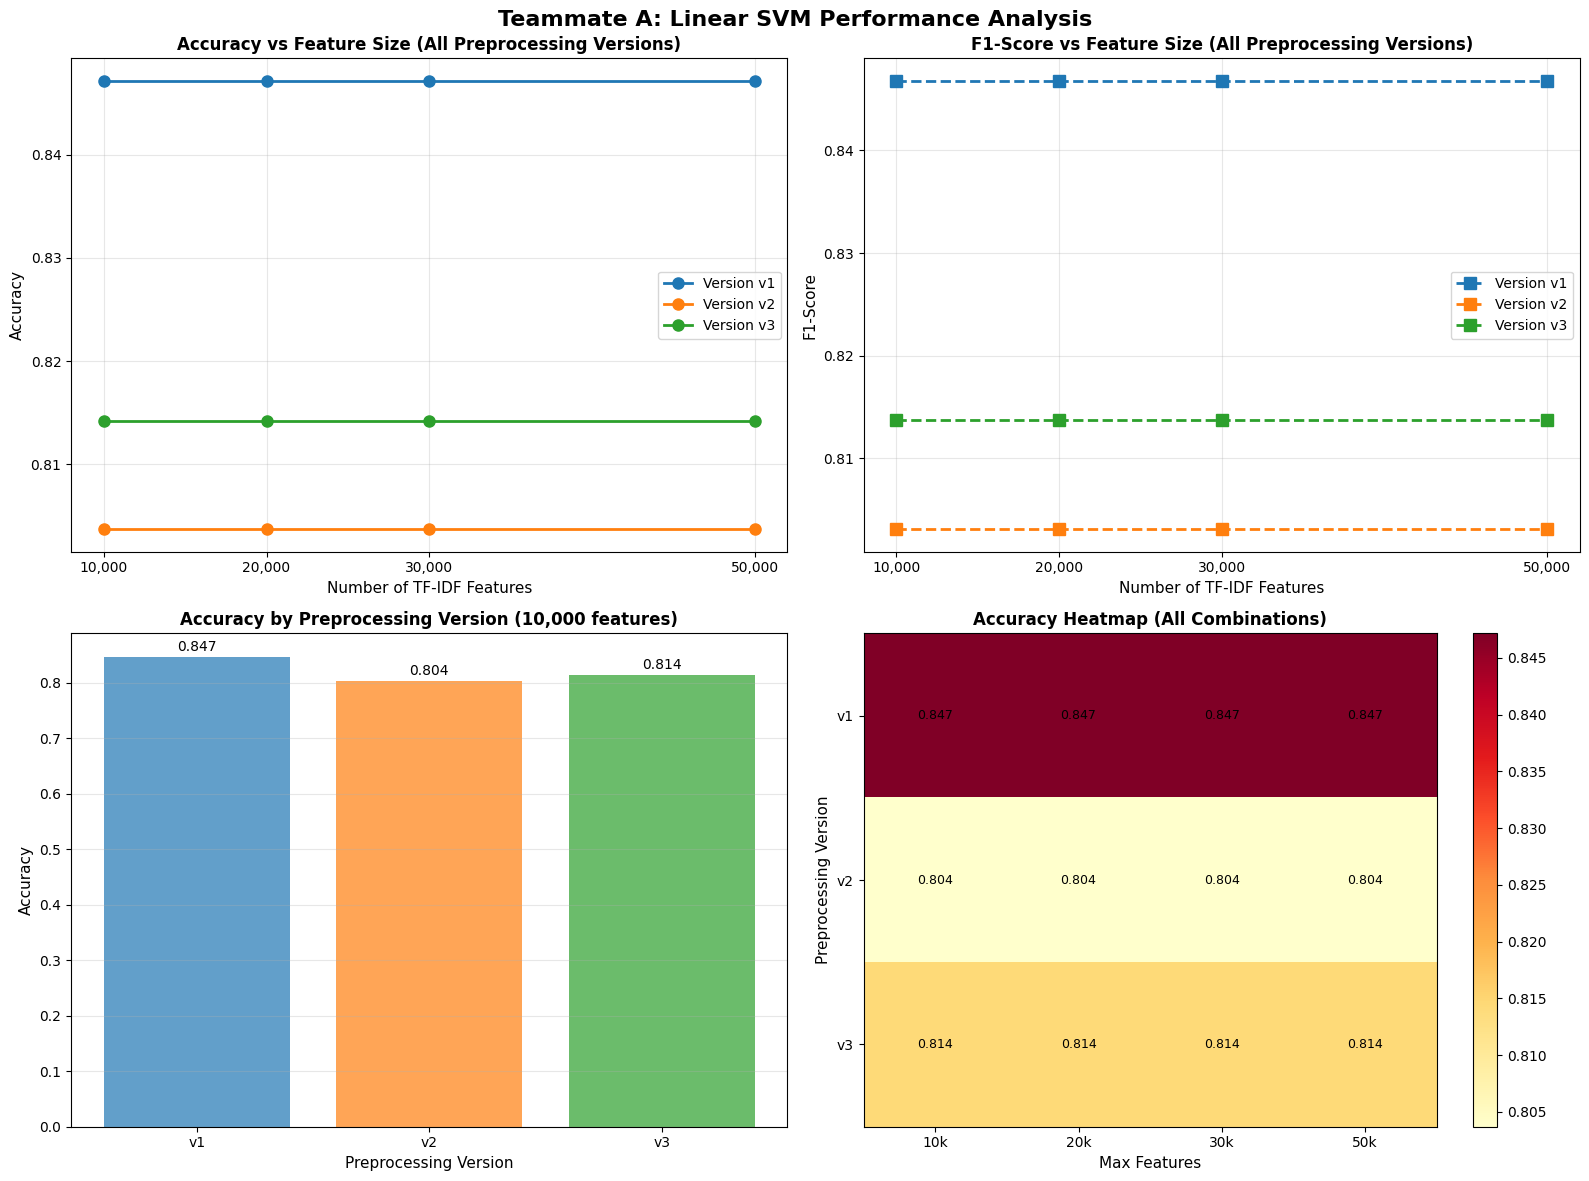

In [ ]:
print("=" * 60)
print("STEP 5.2.4: Performance Visualizations")
print("=" * 60)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Teammate A: Linear SVM Performance Analysis', fontsize=16, fontweight='bold')

# Plot 1: Accuracy by Feature Size (all preprocessing versions)
ax1 = axes[0, 0]
for version in preprocessing_versions:
    version_data = results_df[results_df['Preprocessing'] == version]
    ax1.plot(version_data['Max Features'], version_data['Accuracy'],
             marker='o', linewidth=2, markersize=8, label=f'Version {version}')
ax1.set_xlabel('Number of TF-IDF Features', fontsize=11)
ax1.set_ylabel('Accuracy', fontsize=11)
ax1.set_title('Accuracy vs Feature Size (All Preprocessing Versions)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(feature_sizes)
ax1.set_xticklabels([f'{x:,}' for x in feature_sizes])

# Plot 2: F1-Score by Feature Size (all preprocessing versions)
ax2 = axes[0, 1]
for version in preprocessing_versions:
    version_data = results_df[results_df['Preprocessing'] == version]
    ax2.plot(version_data['Max Features'], version_data['F1-Score'],
             marker='s', linewidth=2, markersize=8, label=f'Version {version}', linestyle='--')
ax2.set_xlabel('Number of TF-IDF Features', fontsize=11)
ax2.set_ylabel('F1-Score', fontsize=11)
ax2.set_title('F1-Score vs Feature Size (All Preprocessing Versions)', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(feature_sizes)
ax2.set_xticklabels([f'{x:,}' for x in feature_sizes])

# Plot 3: Comparison across preprocessing versions (best feature size)
ax3 = axes[1, 0]
best_feature_size = best_result['max_features']
best_size_data = results_df[results_df['Max Features'] == best_feature_size]
ax3.bar(best_size_data['Preprocessing'], best_size_data['Accuracy'],
        color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7)
ax3.set_xlabel('Preprocessing Version', fontsize=11)
ax3.set_ylabel('Accuracy', fontsize=11)
ax3.set_title(f'Accuracy by Preprocessing Version ({best_feature_size:,} features)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(best_size_data['Accuracy']):
    ax3.text(i, v + 0.005, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

# Plot 4: Heatmap of accuracy across all combinations
ax4 = axes[1, 1]
pivot_data = results_df.pivot(index='Preprocessing', columns='Max Features', values='Accuracy')
im = ax4.imshow(pivot_data.values, cmap='YlOrRd', aspect='auto')
ax4.set_xticks(range(len(feature_sizes)))
ax4.set_xticklabels([f'{x//1000}k' for x in feature_sizes])
ax4.set_yticks(range(len(preprocessing_versions)))
ax4.set_yticklabels(preprocessing_versions)
ax4.set_xlabel('Max Features', fontsize=11)
ax4.set_ylabel('Preprocessing Version', fontsize=11)
ax4.set_title('Accuracy Heatmap (All Combinations)', fontsize=12, fontweight='bold')

# Add text annotations to heatmap
for i in range(len(preprocessing_versions)):
    for j in range(len(feature_sizes)):
        text = ax4.text(j, i, f'{pivot_data.values[i, j]:.3f}', ha="center", va="center", color="black", fontsize=9)

plt.colorbar(im, ax=ax4)

plt.tight_layout()
plt.show()

print("=" * 60)

In [77]:
# save best SVM model
import joblib

joblib.dump(vectorizer, "tfidf_vectorizer.joblib")
joblib.dump(best_svm_model, "best_svm_model.pkl")

['best_svm_model.pkl']

### **5.4 Deep Learning Models**

**Responsible:** Elize Dracopoulos

**Models:**
- LSTM and BiLSTM classifiers
- DistilBERT fine-tuning

**Objective:** Evaluate and compare the performance of deep learning models (LSTM, BiLSTM, and DistilBERT) across all preprocessing versions, and identify which architecture provides the highest accuracy and most robust generalization for the text classification task.

**Experiments:**
- BiLSTM
  - Test 3 preprocessing versions (v1, v2, v3)
  - Test 3 numbers of epochs (3, 5, 10) -- lower as BiLSTM learns earlier due to complexity
  - Compare performance across all combinations
  - Select best model configuration
- LSTM
  - Compare best BiLSTM with LSTM of similar architecture (add epochs to account for reduced complexity)
- Bert
  - Train on 3 epohcs and compare results with best BiLSTM/LSTM contender


#### **5.4.1 LSTM and BiLSTM**


In [ ]:
# Necessary imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from collections import Counter
from sklearn.metrics import accuracy_score

In [ ]:
# Embedding Helper functions
def tokenize(text):
    return text.lower().split()

def build_vocab(texts, min_freq=2):
    counter = Counter()

    for t in texts:
        counter.update(tokenize(t))

    vocab = {"<PAD>": 0, "<UNK>": 1}

    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)

    return vocab

def encode(text, vocab, max_len=30):
    tokens = tokenize(text)
    ids = [vocab.get(tok, vocab["<UNK>"]) for tok in tokens]

    # Pad or truncate
    if len(ids) < max_len:
        ids += [vocab["<PAD>"]] * (max_len - len(ids))
    else:
        ids = ids[:max_len]

    return ids

**5.4.1.1 Extract and Clean Titles from URLs**

In [ ]:
class LSTMClassifier(nn.Module):
        def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=2, bidirectional=False):
            super().__init__()
            self.embedding = nn.Embedding(vocab_size, embed_dim)
            self.lstm = nn.LSTM(
                embed_dim,
                hidden_dim,
                batch_first=True,
                bidirectional=bidirectional
            )
            direction_factor = 2 if bidirectional else 1
            self.fc = nn.Linear(hidden_dim * direction_factor, num_classes)

        def forward(self, x):
            x = self.embedding(x)
            out, (h, c) = self.lstm(x)
            if self.lstm.bidirectional:
                h_last = torch.cat((h[0], h[1]), dim=1) # accounts both forward and backward LSTM hidden states
            else:
                h_last = h[-1] # For unidirectional, take the last layer's last hidden state
            logits = self.fc(h_last)
            return logits

**5.4.1.2 Train and evaluate model on varying number of epochs and preprocessing versions**

In [ ]:
models = []
accuracies = []
len_vocab = []
versions = ['v1', 'v2', 'v3']
epochs = [3, 5, 10]

test_loaders = [] # for later evaluations

for version in versions:
    print(f"\n{'=' * 60}")
    print(f"Testing Preprocessing Version {version}")
    print(f"{'=' * 60}")

    # Split train and test data
    X_train = splits[version]['X_train']
    X_test = splits[version]['X_test']
    y_train = splits[version]['y_train']
    y_test = splits[version]['y_test']

    # Encode text and create data loaders
    texts = df_cleaning[f"headline_{version}"].astype(str)

    vocab = build_vocab(X_train)
    print("Vocab size (for embedding):", len(vocab))

    X_train_tokens = [encode(t, vocab) for t in X_train]
    X_test_tokens  = [encode(t, vocab) for t in X_test]

    y_train = np.array(y_train, dtype=np.int64)
    y_test = np.array(y_test, dtype=np.int64)

    train_ds = TensorDataset(
        torch.tensor(X_train_tokens, dtype=torch.long),
        torch.tensor(y_train, dtype=torch.long)
    )

    test_ds = TensorDataset(
        torch.tensor(X_test_tokens, dtype=torch.long),
        torch.tensor(y_test, dtype=torch.long)
    )

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=32)

    test_loaders.append(test_loader)
    len_vocab.append(len(vocab))

    # define model, using the correct vocab size
    lstm_model = LSTMClassifier(len(vocab), bidirectional=True)
    optimizer = optim.Adam(lstm_model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    for num_epochs in epochs:
      print(f"Training with {num_epochs} epochs...")
      # Training loop
      for epoch in range(num_epochs):
          lstm_model.train()

          for X, y in train_loader:
              optimizer.zero_grad()
              logits = lstm_model(X)
              loss = loss_fn(logits, y)
              loss.backward()
              optimizer.step()

          print(f"Epoch {epoch + 1} completed.")

      # Evaluation
      lstm_model.eval()
      preds = []

      with torch.no_grad():
          for X, _ in test_loader:
              logits = lstm_model(X)
              p = logits.argmax(dim=1)
              preds.extend(p.cpu().numpy())

      # Compute accuracy
      lstm_accuracy = accuracy_score(y_test, preds)
      accuracies.append(lstm_accuracy)

      models.append(lstm_model)

      print("LSTM Accuracy:", lstm_accuracy)


Testing Preprocessing Version v1
Vocab size (for embedding): 3581
Training with 3 epochs...
Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
LSTM Accuracy: 0.8115942028985508
Training with 5 epochs...
Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
LSTM Accuracy: 0.8063241106719368
Training with 10 epochs...
Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
Epoch 6 completed.
Epoch 7 completed.
Epoch 8 completed.
Epoch 9 completed.
Epoch 10 completed.
LSTM Accuracy: 0.8063241106719368

Testing Preprocessing Version v2
Vocab size (for embedding): 3476
Training with 3 epochs...
Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
LSTM Accuracy: 0.7628458498023716
Training with 5 epochs...
Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
LSTM Accuracy: 0.7878787878787878
Training with 10 epochs...
Epoch 1 completed.
Epoch 2 completed.
Epoch

In [ ]:
# find best model / best epoch, preprocessing version balance
index = np.argmax(accuracies)
best_lstm_model = models[index]

v = index // 3
e = epochs[index % 3]

dataloader = test_loaders[v] # choose vocab from best model
vocab_len = len_vocab[v]

print(f"Highest Accuracy Preprocessing: Version {v + 1}")
print(f"Highest Accuracy Epoch: {e}")
print(f"Best Accuracy: {accuracies[index]}")

Highest Accuracy Preprocessing: Version 3
Highest Accuracy Epoch: 5
Best Accuracy: 0.8181818181818182


**5.4.1.3 Compare to unidirectional LSTM and choose lowest accuracy model**

In [ ]:
# Compare to simple LSTM
lstm_model = LSTMClassifier(vocab_len, bidirectional=False)
optimizer = optim.Adam(lstm_model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(e + 3): # add epochs to account for decreased complexity
    lstm_model.train()

    for X, y in dataloader:
        optimizer.zero_grad()
        logits = lstm_model(X)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1} completed.")

# Evaluation
lstm_model.eval()
preds = []

with torch.no_grad():
    for X, _ in dataloader:
        logits = lstm_model(X)
        p = logits.argmax(dim=1)
        preds.extend(p.cpu().numpy())

# Compute accuracy
lstm_accuracy = accuracy_score(y_test, preds)

print("LSTM Accuracy:", lstm_accuracy)

Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
Epoch 6 completed.
Epoch 7 completed.
Epoch 8 completed.
LSTM Accuracy: 0.5270092226613966


In [ ]:
# select best-performing model
if lstm_accuracy > accuracies[index]:
    best_lstm_model = lstm_model
else:
  lstm_accuracy = accuracies[index]

In [ ]:
# display classification report
from sklearn.metrics import classification_report

# Pick the best model
best_lstm_model.eval()

preds = []

with torch.no_grad():
    for X, _ in dataloader:
        logits = best_lstm_model(X)
        p = logits.argmax(dim=1)
        preds.extend(p.cpu().numpy()) # model running on gpu

# Print classification report
print(classification_report(y_test, preds, digits=4))

              precision    recall  f1-score   support

           0     0.8096    0.8400    0.8245       400
           1     0.8140    0.7799    0.7966       359

    accuracy                         0.8116       759
   macro avg     0.8118    0.8100    0.8106       759
weighted avg     0.8117    0.8116    0.8113       759



**5.4.1.4 Visulaize and Compare Results**

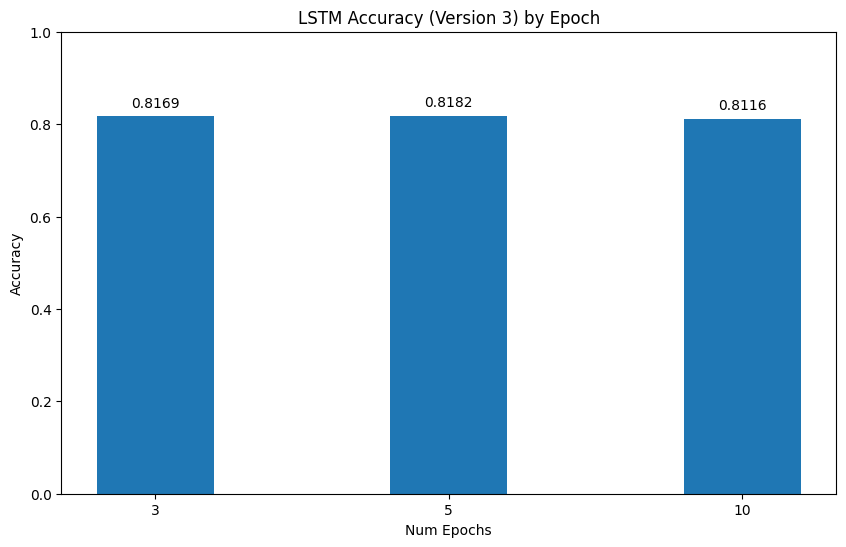

In [ ]:
plt.figure(figsize=(10,6))

x = [0, 1, 2]
y = accuracies[start:start+3]
epochs_to_plot = epochs

plt.bar(x, y, width=0.4)

plt.xticks(x, epochs_to_plot)
plt.xlabel("Num Epochs")
plt.ylabel("Accuracy")
plt.title(f"LSTM Accuracy (Version {index // 3 + 1}) by Epoch")

plt.ylim(0.0, 1.0)

for i, v in enumerate(y):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')

plt.show()

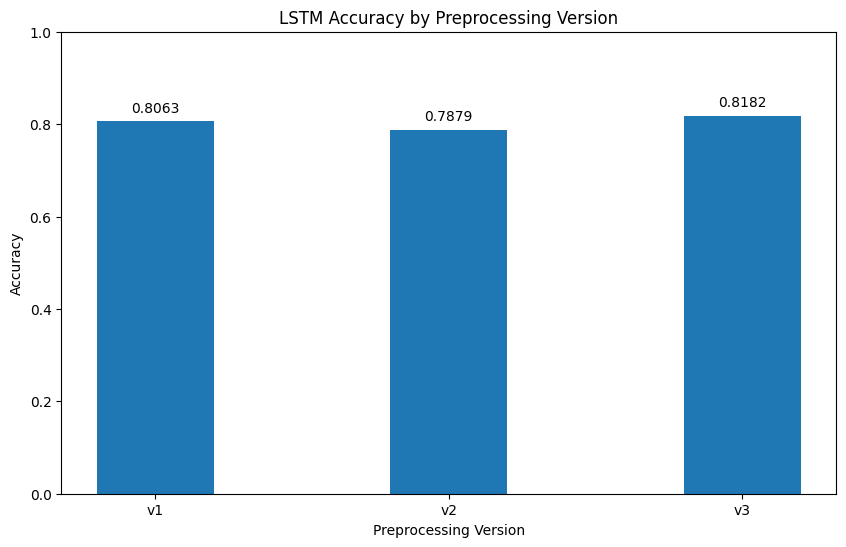

In [ ]:
plt.figure(figsize=(10,6))
x = ['v1', 'v2', 'v3']

y = [accuracies[index % 3 + 3 * i] for i in range(3)]

plt.bar(x, y, width=0.4)
plt.xlabel('Preprocessing Version')
plt.ylabel('Accuracy')
plt.title('LSTM Accuracy by Preprocessing Version')

plt.ylim(0.0, 1.0)
for i, v in enumerate(y):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', color='black')
plt.show()

In [ ]:
# save model
torch.save(lstm_model.state_dict(), "lstm_model.pt")

#### **5.4.2 DistilBERT fine-tuning**

In [ ]:
# imports and tokenizer
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import Dataset

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


**5.4.2.1 Prepare input data**

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_encodings = tokenizer(
    X_train.tolist(),
    truncation=True,
    padding=True,
    max_length=64
)

test_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding=True,
    max_length=64
)

train_ds = NewsDataset(train_encodings, y_train)
test_ds  = NewsDataset(test_encodings, y_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=16)

**5.4.2.2 Initialize model**

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


**5.4.2.3 Train model (should take roughly 10 minutes per epoch)**

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3

model.train()
for epoch in range(num_epochs):
    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} completed. Loss = {loss.item():.4f}")

Epoch 1 completed. Loss = 0.3894
Epoch 2 completed. Loss = 0.0903
Epoch 3 completed. Loss = 0.0063


**5.4.2.4 Evaluate Model based on accuracy**

In [ ]:
model.eval()
preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        ).logits

        preds.extend(torch.argmax(logits, dim=1).cpu().numpy())

In [ ]:
bert_accuracy = accuracy_score(y_test, preds)

print("Bert Accuracy:", bert_accuracy)

Bert Accuracy: 0.8840579710144928


In [ ]:
# Save model
torch.save(model.state_dict(), "bert_ model.pt")

---

## **6. Model Comparison & Selection**

This section evaluates all models, compares their performance, and selects the best model for leaderboard submission.


### **6.1 Compare All Models**

**Tasks:**
- Compare performance across all models and preprocessing versions
- Identify best-performing model
- Document model selection rationale


In [ ]:
svm_accuracy = np.max(best_size_data['Accuracy'])

In [ ]:
final_accuracies = []

final_accuracies.append(baseline_accuracy)
final_accuracies.append(svm_accuracy)
final_accuracies.append(lstm_accuracy)
final_accuracies.append(bert_accuracy)

In [ ]:
model_names = [
    "Baseline Logistic Regression",
    "Linear SVM",
    "LSTM",
    "DistilBERT"
]

print("\n" + "=" * 60)
print("Final Model Accuracies:")
print("=" * 60)

for i, acc in enumerate(final_accuracies):
    print(f"   {model_names[i]}: {acc:.4f} ({acc*100:.2f}%) accuracy")


Final Model Accuracies:
   Baseline Logistic Regression: 0.7057 (70.57%) accuracy
   Linear SVM: 0.8472 (84.72%) accuracy
   LSTM: 0.8182 (81.82%) accuracy
   DistilBERT: 0.8841 (88.41%) accuracy


In [ ]:
idx = np.argmax(final_accuracies)
print(f"Best performing model: {model_names[idx]}")
print(f"Accuracy: {final_accuracies[idx]:.4f} ({final_accuracies[idx]*100:.2f}%)")

Best performing model: DistilBERT
Accuracy: 0.8841 (88.41%)


### **6.2 Results Visualization**

**Required Visualizations:**
- Charts showing model improvements over baseline (required by project spec)
- Confusion matrices for best models

#### **6.2.1 Final Model Accuracy Comparison**

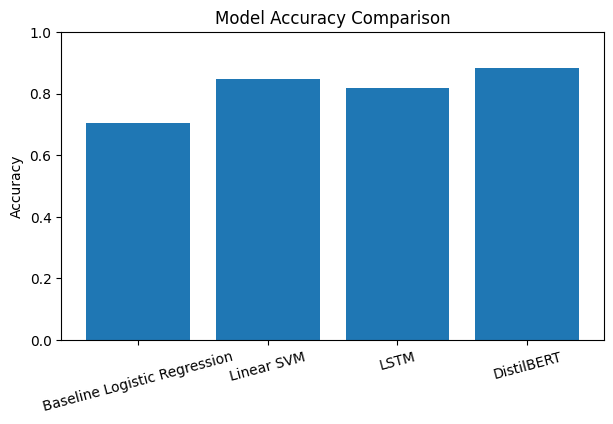

In [ ]:
import matplotlib.pyplot as plt

accuracies = final_accuracies
models = model_names

plt.figure(figsize=(7,4))
plt.bar(models, accuracies)
plt.ylabel("Accuracy")
plt.ylim(0.65, 0.8)
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=15)
plt.ylim(0.0, 1.0)
plt.show()

#### **6.2.2 Model Improvements over the Baseline**

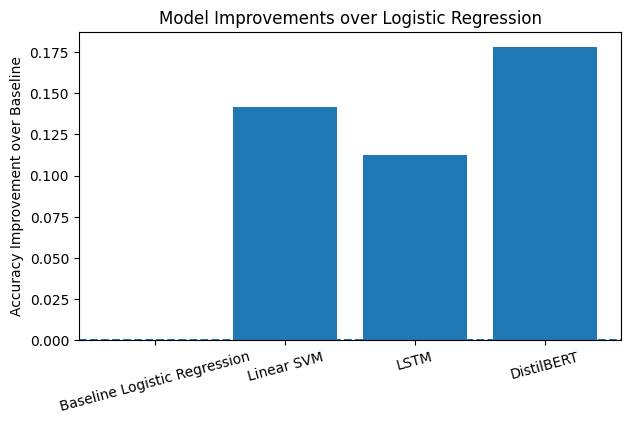

In [ ]:
baseline = final_accuracies[0]
improvement = [acc - baseline for acc in final_accuracies]

plt.figure(figsize=(7,4))
plt.bar(models, improvement)
plt.axhline(0, linestyle="--")
plt.ylabel("Accuracy Improvement over Baseline")
plt.title("Model Improvements over Logistic Regression")
plt.xticks(rotation=15)
plt.show()

#### **6.2.3 Confusion Matrix**

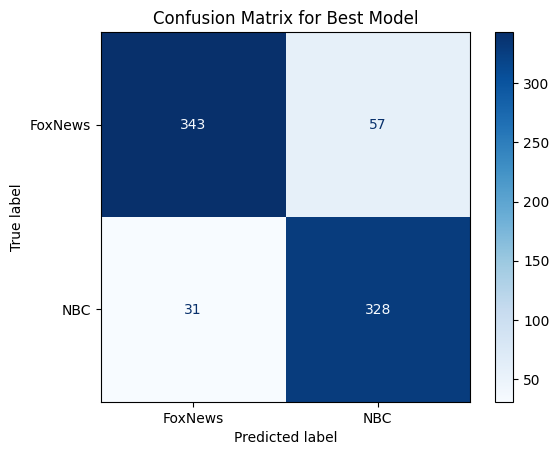

In [ ]:
# bert -- best model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["FoxNews", "NBC"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Best Model")
plt.show()

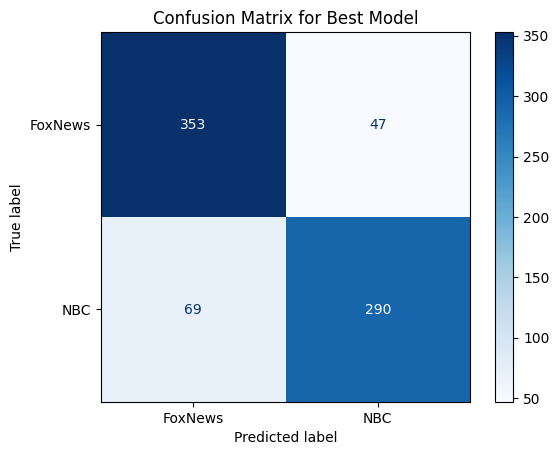

In [76]:
# SVM confusion matrix
cm_svm = confusion_matrix(y_test_best, y_pred_best)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_svm,
    display_labels=["FoxNews", "NBC"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Best Model")
plt.show()


---

## **7. Exploratory Components**

### **7.1 Dataset: Automated Daily Headline Collector using GitHub Actions**

**Responsible:** Maya Kfir

**GitHub Repository:** [fox-nbc-news-daily-headline-scraper](https://github.com/maya2816/fox-nbc-news-daily-headline-scraper)

This exploratory component implements an automated system that collects headlines from Fox News and NBC News homepages daily to address temporal drift in news classification tasks.

**System Key Features:**

1. **Automated Daily Collection:** Collects headlines from both Fox News and NBC News homepages every day at 2 AM UTC via GitHub Actions
2. **Balanced Sampling:** Implements balanced class distribution by finding the minimum headline count between sources and randomly sampling that amount from each, ensuring perfect 50/50 split
3. **Custom HTML Parsing:** Implements source-specific scraping functions tailored to each news site's unique HTML structure
4. **Robust Filtering:** Excludes non-headline content (video titles, sponsored content, image credits, photographer names)
5. **Duplicate Detection:** Performs case-insensitive duplicate detection to ensure dataset integrity
6. **Data Integration:** Seamlessly integrates new headlines with existing dataset while preserving historical data
7. **Scraping Reports:** Generates detailed reports tracking metrics per scraping session (total scraped, by source, added vs duplicates, dataset size changes)

**Results:** The system successfully collects approximately 100-200 headlines per day with perfectly balanced distribution (50/50) between Fox News and NBC News after sampling.

#### **7.1.1 Load Daily Scraped Data from GitHub**

Load the dynamically updated dataset and scraping report directly from the GitHub repository.

In [ ]:
# Load daily updated headlines dataset from GitHub
import pandas as pd
import requests
from io import StringIO

# GitHub repository details
GITHUB_USER = "maya2816"
REPO_NAME = "fox-nbc-news-daily-headline-scraper"
BRANCH = "main"
DATA_PATH = "data/daily_updated_headlines_data.csv"
REPORT_PATH = "data/scraping_report.csv"

# Construct raw GitHub URLs
def get_github_raw_url(file_path):
    """Construct raw GitHub URL for a file"""
    return f"https://raw.githubusercontent.com/{GITHUB_USER}/{REPO_NAME}/{BRANCH}/{file_path}"

# Load daily updated headlines dataset
print("Loading daily updated headlines dataset from GitHub...")
try:
    daily_headlines_url = get_github_raw_url(DATA_PATH)
    df_daily = pd.read_csv(daily_headlines_url)
    print(f"Successfully loaded {len(df_daily)} headlines from GitHub")
    print(f"  URL: {daily_headlines_url}")
except Exception as e:
    print(f"Error loading dataset: {e}")
    df_daily = None


Loading daily updated headlines dataset from GitHub...
Successfully loaded 4088 headlines from GitHub
  URL: https://raw.githubusercontent.com/maya2816/fox-nbc-news-daily-headline-scraper/main/data/daily_updated_headlines_data.csv


In [ ]:
# Load scraping report from GitHub
print("\n" + "=" * 60)
print("Loading scraping report from GitHub...")
try:
    report_url = get_github_raw_url(REPORT_PATH)
    df_report = pd.read_csv(report_url)
    print(f"Successfully loaded scraping report with {len(df_report)} entries")
    print(f"  URL: {report_url}")
except Exception as e:
    print(f"Error loading report: {e}")
    print("  Note: Report may not exist yet if scraper hasn't run")
    df_report = None


Loading scraping report from GitHub...
Successfully loaded scraping report with 3 entries
  URL: https://raw.githubusercontent.com/maya2816/fox-nbc-news-daily-headline-scraper/main/data/scraping_report.csv


Dataset overview and basic statistics:

In [ ]:
if df_daily is not None:
    print("\n" + "=" * 60)
    print("Daily Updated Headlines Dataset Overview")
    print("=" * 60)
    print(f"\nTotal headlines: {len(df_daily)}")
    print(f"\nSource distribution:")
    if 'source' in df_daily.columns:
        source_counts = df_daily['source'].value_counts()
        for source, count in source_counts.items():
            percentage = (count / len(df_daily)) * 100
            print(f"  {source}: {count} ({percentage:.1f}%)")

    print(f"\nCollection date distribution (latest 10 dates):")
    if 'collection_date' in df_daily.columns:
        date_counts = df_daily['collection_date'].value_counts().head(10)
        for date, count in date_counts.items():
            print(f"  {date}: {count} headlines")


Daily Updated Headlines Dataset Overview

Total headlines: 4088

Source distribution:
  FoxNews: 2225 (54.4%)
  NBC: 1863 (45.6%)

Collection date distribution (latest 10 dates):
  initial: 3785 headlines
  2025-12-12: 215 headlines
  2025-12-14: 67 headlines
  2025-12-13: 21 headlines


#### **7.1.2 Dataset Visualizations**

Visualize the source distribution and collection trends.

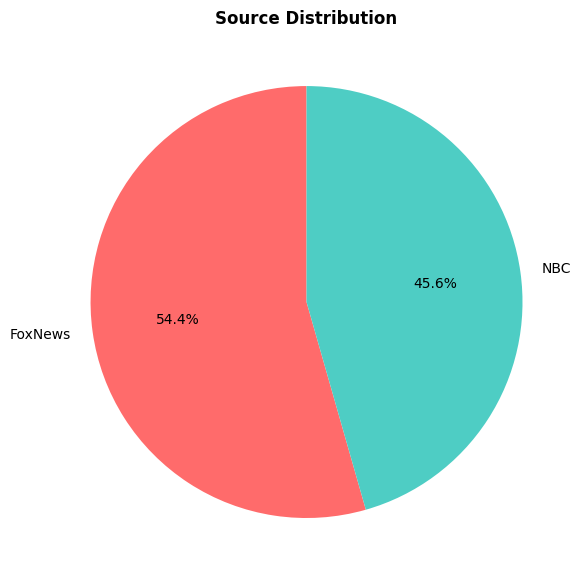

In [ ]:
# Visualization 1: Source Distribution Pie Chart
if df_daily is not None and 'source' in df_daily.columns:
    source_counts = df_daily['source'].value_counts()
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.pie(source_counts.values, labels=source_counts.index, autopct='%1.1f%%',
           startangle=90, colors=['#FF6B6B', '#4ECDC4'])
    ax.set_title('Source Distribution', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

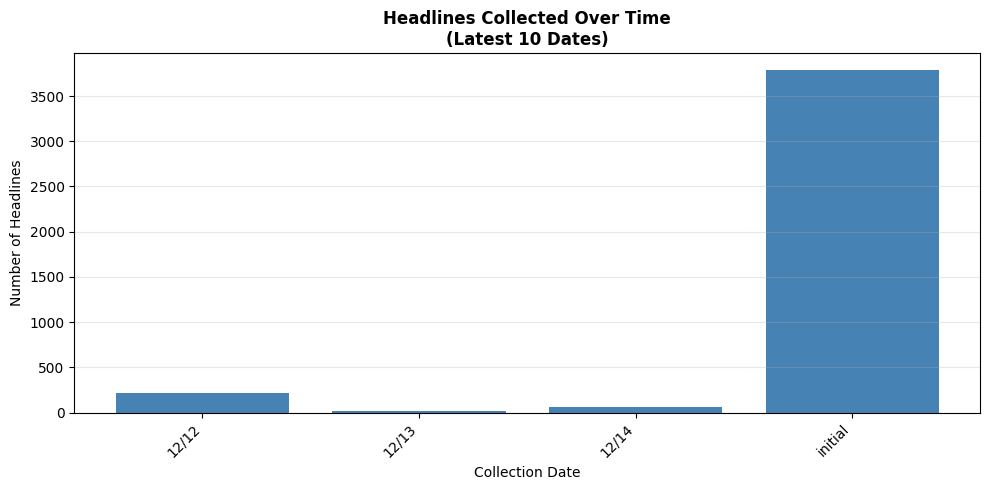

In [ ]:
# Visualization 2: Headlines Collected Over Time (Bar Chart)
if df_daily is not None and 'collection_date' in df_daily.columns:
    date_counts = df_daily['collection_date'].value_counts().sort_index().tail(10)
    if len(date_counts) > 0:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.bar(range(len(date_counts)), date_counts.values, color='steelblue')
        ax.set_xticks(range(len(date_counts)))

        # Format date labels safely
        date_labels = []
        for d in date_counts.index:
            try:
                if isinstance(d, str) and '-' in d:
                    parts = d.split('-')
                    if len(parts) >= 3:
                        date_labels.append(f"{parts[1]}/{parts[2]}")
                    else:
                        date_labels.append(str(d)[:10])
                else:
                    date_labels.append(str(d)[:10])
            except:
                date_labels.append(str(d)[:10])

        ax.set_xticklabels(date_labels, rotation=45, ha='right')
        ax.set_xlabel('Collection Date', fontsize=10)
        ax.set_ylabel('Number of Headlines', fontsize=10)
        ax.set_title('Headlines Collected Over Time\n(Latest 10 Dates)', fontsize=12, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

#### **7.1.3 Scraping Report Analysis**

Display scraping statistics and visualize collection metrics.

In [ ]:
# Display scraping report summary statistics
if df_report is not None:
    print("\n" + "=" * 60)
    print("Scraping Report Overview")
    print("=" * 60)
    print(f"\nTotal scraping sessions: {len(df_report)}")
    print(f"\nLatest scraping sessions:")
    print(df_report.tail(10).to_string(index=False))

    # Summary statistics
    if len(df_report) > 0:
        print(f"\n" + "=" * 60)
        print("Summary Statistics")
        print("=" * 60)
        print(f"Average headlines scraped per session: {df_report['total_headlines_scraped'].mean():.1f}")
        print(f"Average headlines added per session: {df_report['headlines_added'].mean():.1f}")
        print(f"Average duplicates skipped per session: {df_report['duplicates_skipped'].mean():.1f}")
else:
    print("\nNo scraping report available yet.")
    print("The report will be created after the first automated scraping session runs.")


Scraping Report Overview

Total scraping sessions: 3

Latest scraping sessions:
scraping_date  total_headlines_scraped  fox_news_count  nbc_news_count  headlines_added  duplicates_skipped  dataset_size_before  dataset_size_after
   2025-12-12                      209             178              31                7                 202                 3993                4000
   2025-12-13                       72              36              36               21                  51                 4000                4021
   2025-12-14                       80              40              40               67                  13                 4021                4088

Summary Statistics
Average headlines scraped per session: 120.3
Average headlines added per session: 31.7
Average duplicates skipped per session: 88.7


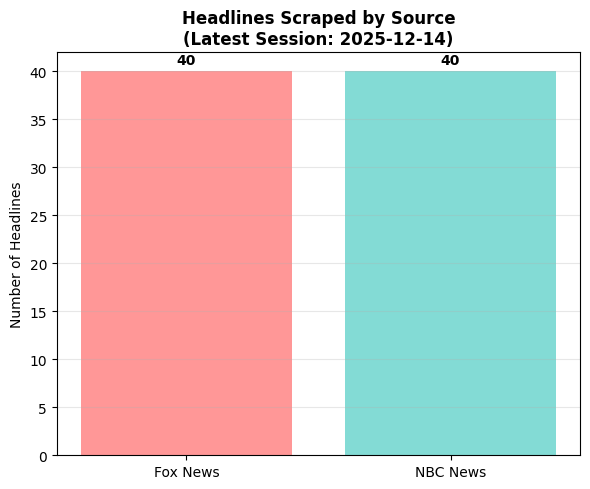

In [ ]:
# Visualization 3: Headlines Scraped by Source (Latest Session)
if df_report is not None and len(df_report) > 0:
    if 'fox_news_count' in df_report.columns and 'nbc_news_count' in df_report.columns:
        latest = df_report.iloc[-1]
        sources = ['Fox News', 'NBC News']
        counts = [latest['fox_news_count'], latest['nbc_news_count']]
        colors = ['#FF6B6B', '#4ECDC4']

        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        ax.bar(sources, counts, color=colors, alpha=0.7)
        ax.set_ylabel('Number of Headlines', fontsize=10)
        ax.set_title(f'Headlines Scraped by Source\n(Latest Session: {latest["scraping_date"]})',
                     fontsize=12, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        # Add value labels on bars
        for i, (source, count) in enumerate(zip(sources, counts)):
            ax.text(i, count + max(counts)*0.01, str(int(count)),
                    ha='center', va='bottom', fontweight='bold')
        plt.tight_layout()
        plt.show()

### **7.2 Dataset: Embedding Space Visualization and Analysis**

**Objective:** To explore how classical feature engineering (TF-IDF) and neural representation learning (LSTM hidden states) differ in their ability to capture semantic distinctions between news sources.

#### **7.2.1 TF-IDF Embedding Visualization**


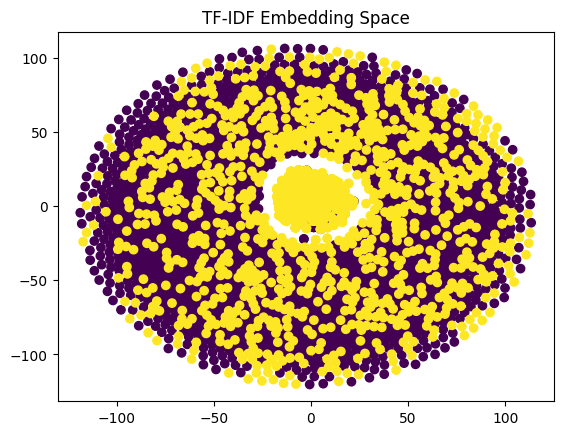

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

vec = TfidfVectorizer(max_features=2000)
X_tfidf = vec.fit_transform(df["headline"]).toarray()

X_tfidf_2d = TSNE(n_components=2, perplexity=30).fit_transform(X_tfidf)

if "source" in df.columns:
    df.rename(columns={"source": "label"}, inplace=True)

plt.scatter(X_tfidf_2d[:,0], X_tfidf_2d[:,1], c=df["label"].map({"FoxNews":0,"NBC":1}))
plt.title("TF-IDF Embedding Space")
plt.show()

#### **7.2.2 LSTM Embedding Visualization**

Embeddings: (759, 256)
Labels: (759,)


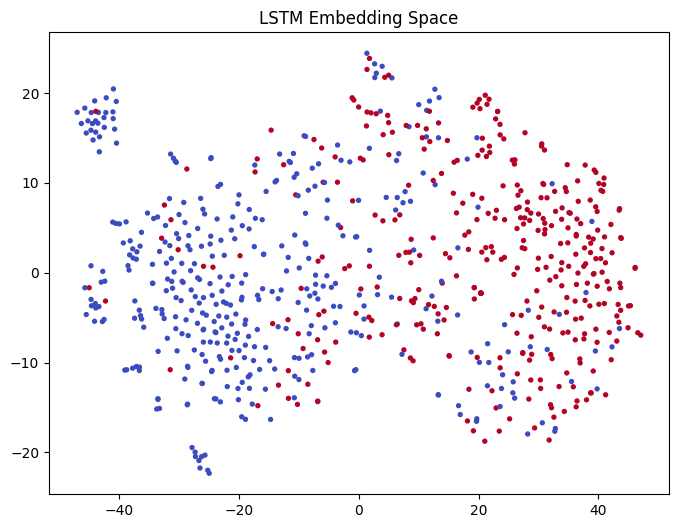

In [ ]:
from sklearn.manifold import TSNE

best_lstm_model.eval()
embeddings = []
all_labels = []

with torch.no_grad():
    for batch in dataloader:

        # Handle batch structure
        if isinstance(batch, dict):
            X = batch["input_ids"]
            y = batch["labels"]
        else:
            X, y = batch

        # 2. Token embedding lookup
        emb = best_lstm_model.embedding(X)

        # 3. Pass through LSTM
        out, (h, c) = best_lstm_model.lstm(emb)

        # 4. Handle bi/unidirectional
        if best_lstm_model.lstm.bidirectional:
            final_h = torch.cat((h[0], h[1]), dim=1)
        else:
            final_h = h[-1]

        # Save embeddings + labels
        embeddings.append(final_h.cpu().numpy())
        all_labels.extend(y.cpu().numpy())   # <-- FIX

# Convert lists to arrays
X_lstm = np.vstack(embeddings)
all_labels = np.array(all_labels)

print("Embeddings:", X_lstm.shape)
print("Labels:", all_labels.shape)

# t-SNE
X_lstm_2d = TSNE(n_components=2, perplexity=30).fit_transform(X_lstm)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(
    X_lstm_2d[:,0],
    X_lstm_2d[:,1],
    c=all_labels,
    cmap='coolwarm',
    s=8
)
plt.title("LSTM Embedding Space")
plt.show()


**Obseravations:** The TF-IDF embedding space shows substantial overlap between the two sources, indicating limited separability using bag-of-words features. In contrast, the LSTM embedding space exhibits clearer clustering by source, suggesting that the model learns higher-level semantic representations beyond word frequency, and is thus better able to differentiate the articles.